# MATH Dataset: Experiments & Paper Figures

**Step 2 of 2**: Load pre-generated data, run adaptive + baseline algorithms, produce all figures.

Requires output from `math_pregenerate.ipynb`.

## Sections
1. Setup & data loading
2. Weak verifier quality analysis (distribution + calibration)
3. Error convergence plots
4. Main pipeline: accuracy vs latency (symmetric α=β)
5. Appendix sweeps: fixed-α and fixed-β
6. Multi-sweep overlay plots
7. Reload & re-plot (for rebuttals)

## 1. Setup

In [1]:
import sys
sys.path.insert(0, '..')

import copy
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src.utils import load_pregenerated_data

# Analysis: weak verifier quality
from src.math_experiments import (
    plot_score_distribution,
    plot_calibration,
    print_weak_verifier_summary,
)

# Simulation: error convergence
from src.math_experiments import (
    run_with_error_tracking_per_diff_config,
    plot_error_summary_with_convergence,
    plot_accept_error_convergence,
    plot_reject_error_convergence,
    plot_both_error_convergence,
)

# Pipeline: grid search + accuracy vs latency
from src.math_experiments import (
    run_full_pipeline,
    plot_accuracy_vs_latency,
    save_pipeline_results,
    load_pipeline_results,
)

# Sweep plots (appendix)
from src.math_experiments import (
    plot_accuracy_vs_latency_multi_alpha,
    plot_accuracy_vs_latency_multi_beta,
)

RESULTS_DIR = '../results'
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

print('='*70)
print('BEST-OF-N ADAPTIVE VERIFICATION EXPERIMENTS')
print('='*70)
print(f'Results directory: {RESULTS_DIR}')

BEST-OF-N ADAPTIVE VERIFICATION EXPERIMENTS
Results directory: ../results


In [2]:
# Load pregenerated data
# UPDATE the path to your actual pregenerated file
PREGENERATED_PATH = "../results/pregenerated_math_dataset_20260114_231839.json"  # <- UPDATE THIS

pregenerated_data = load_pregenerated_data(PREGENERATED_PATH)

for diff in sorted(pregenerated_data['data'].keys()):
    n = len(pregenerated_data['data'][diff])
    print(f'  Difficulty {diff}: {n} problems')

  Difficulty 2: 200 problems
  Difficulty 3: 200 problems
  Difficulty 5: 200 problems


In [3]:
# Optional: repeat dataset for more training signal
def create_repeated_data(data, repeat_factor=10):
    repeated = copy.deepcopy(data)
    for difficulty in repeated['data']:
        original = dict(repeated['data'][difficulty])
        repeated['data'][difficulty] = {}
        new_idx = 0
        for _ in range(repeat_factor):
            for old_idx, prob_data in original.items():
                repeated['data'][difficulty][new_idx] = copy.deepcopy(prob_data)
                new_idx += 1
    print(f'Created {repeat_factor}x repeated dataset')
    for diff in repeated['data']:
        print(f'  Difficulty {diff}: {len(repeated["data"][diff])} problems')
    return repeated

# Set repeat_factor=1 to use original data, or 10 for more signal
repeated_data = create_repeated_data(pregenerated_data, repeat_factor=1)

Created 1x repeated dataset
  Difficulty 2: 200 problems
  Difficulty 3: 200 problems
  Difficulty 5: 200 problems


## 2. Weak Verifier Quality Analysis

✓ Saved: ../results/score_distribution.png


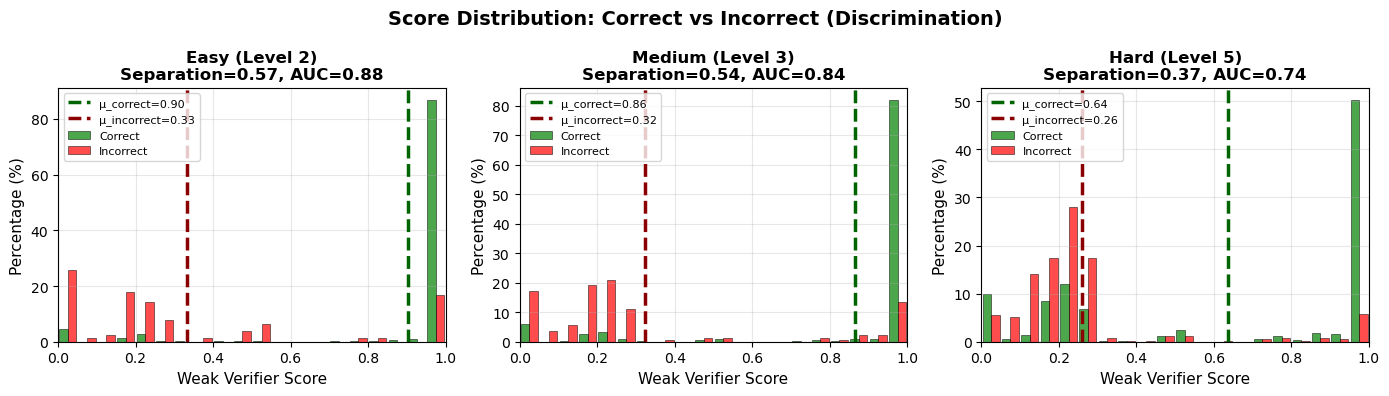

In [4]:
# Score distribution: correct vs incorrect
fig_dist = plot_score_distribution(pregenerated_data, save_dir=RESULTS_DIR)

✓ Saved: ../results/calibration.png


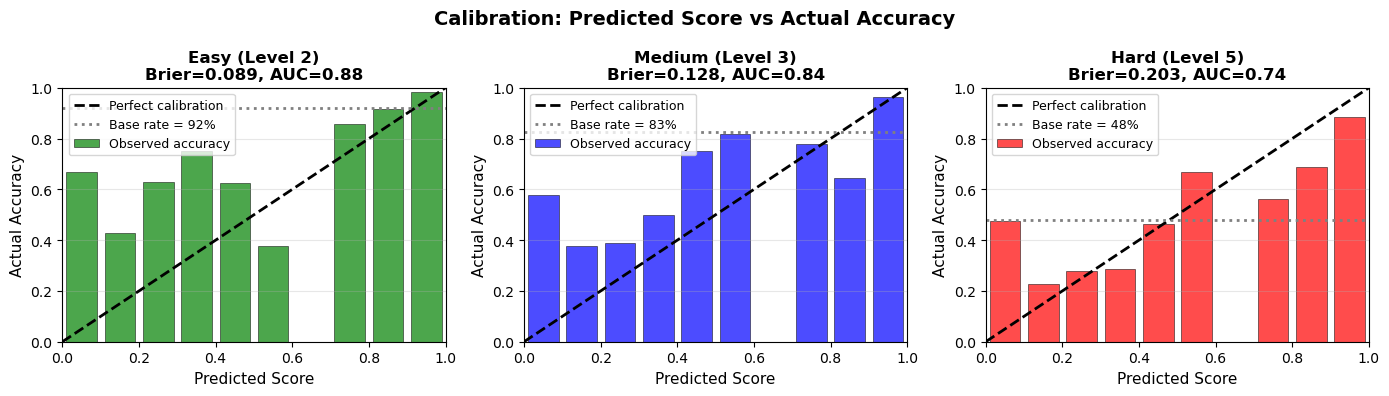

In [5]:
# Calibration: predicted score vs actual accuracy
fig_cal = plot_calibration(pregenerated_data, save_dir=RESULTS_DIR)

In [6]:
# Summary table
print_weak_verifier_summary(pregenerated_data)


WEAK VERIFIER QUALITY SUMMARY

Difficulty | Base Acc   | AUC      | Brier    | μ_correct  | μ_incorrect  | Separation
-----------------------------------------------------------------------------------------------
Easy       | 92.2%      | 0.88     | 0.089    | 0.90       | 0.33         | 0.57      
Medium     | 82.7%      | 0.84     | 0.128    | 0.86       | 0.32         | 0.54      
Hard       | 47.9%      | 0.74     | 0.203    | 0.64       | 0.26         | 0.37      

METRICS EXPLANATION:
- Separation: Mean(correct) - Mean(incorrect). Higher = better discrimination.
- AUC: Probability that a random correct sample scores higher than incorrect.
       0.5 = random, 1.0 = perfect. Higher = better.
- Brier: Mean squared error of predictions. 0 = perfect, 1 = worst. Lower = better.
- Base Acc: Overall accuracy (% of correct attempts in dataset).



## 3. Error Convergence Plots

In [7]:
# Per-difficulty tuned configurations
per_difficulty_configs = {
    2: {  # Easy
        'max_attempts': 5,
        'eta': 0.067,
        'eta_R': 0.05,
        'tau_A_init': 0.7,
        'tau_R_init': 0.15,
        'P_a_init': 0.3,
        'P_r_init': 0.3,
        'P_a_min': 0.3,
        'P_r_min': 0.3,
    },
    3: {  # Medium
        'max_attempts': 5,
        'eta': 0.09,
        'eta_R': 0.02,
        'tau_A_init': 0.9,
        'tau_R_init': 0.15,
        'P_a_init': 0.3,
        'P_r_init': 0.3,
        'P_a_min': 0.3,
        'P_r_min': 0.3,
    },
    5: {  # Hard
        'max_attempts': 5,
        'eta': 0.08,
        'eta_R': 0.1,
        'tau_A_init': 0.8,
        'tau_R_init': 0.15,
        'P_a_init': 0.3,
        'P_r_init': 0.3,
        'P_a_min': 0.3,
        'P_r_min': 0.3,
    },
}

print('Per-difficulty configurations:')
for diff, cfg in per_difficulty_configs.items():
    print(f"  Difficulty {diff}: eta={cfg['eta']}, eta_R={cfg['eta_R']}")

Per-difficulty configurations:
  Difficulty 2: eta=0.067, eta_R=0.05
  Difficulty 3: eta=0.09, eta_R=0.02
  Difficulty 5: eta=0.08, eta_R=0.1


In [8]:
alpha, beta = 0.15, 0.15

print('='*70)
print(f'RUNNING WITH PER-DIFFICULTY CONFIGS (alpha={alpha}, beta={beta})')
print('='*70)

convergence_results = run_with_error_tracking_per_diff_config(
    repeated_data,
    per_difficulty_configs,
    alpha=alpha,
    beta=beta,
)

RUNNING WITH PER-DIFFICULTY CONFIGS (alpha=0.15, beta=0.15)
  Difficulty 2: η=0.067, η_R=0.050, τ_A₀=0.700, τ_R₀=0.150
           264 steps, final accept_err=0.047, final reject_err=0.145
  Difficulty 3: η=0.090, η_R=0.020, τ_A₀=0.900, τ_R₀=0.150
           320 steps, final accept_err=0.069, final reject_err=0.147
  Difficulty 5: η=0.080, η_R=0.100, τ_A₀=0.800, τ_R₀=0.150
           460 steps, final accept_err=0.121, final reject_err=0.124


/Users/nooranis/Desktop/weak-and-strong-verification/notebooks/../src/math_experiments/simulation.py:370: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Saved: ../results/error_summary_with_convergence.png


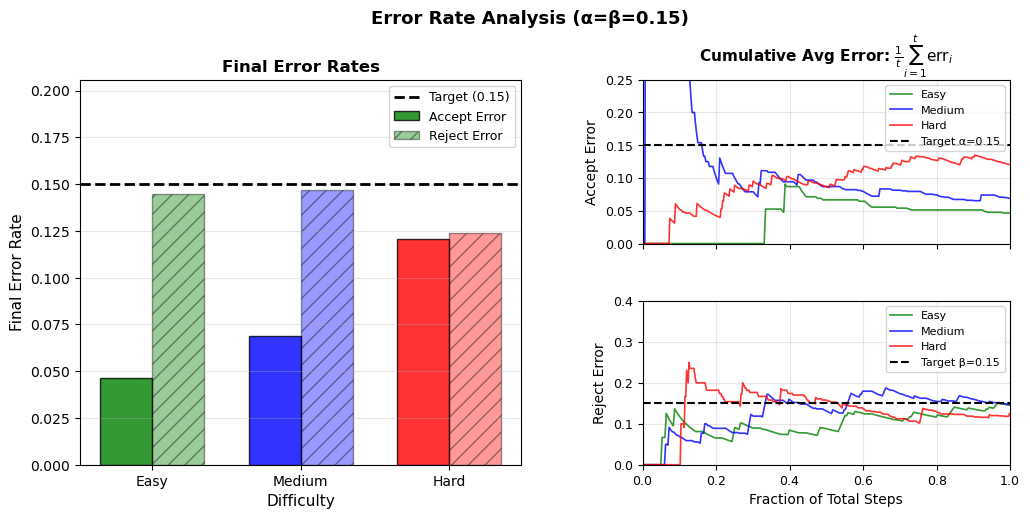

In [9]:
# Summary bar chart + convergence
fig_summary = plot_error_summary_with_convergence(
    convergence_results, alpha=alpha, beta=beta, save_dir=RESULTS_DIR
)

✓ Saved: ../results/accept_error_convergence.png


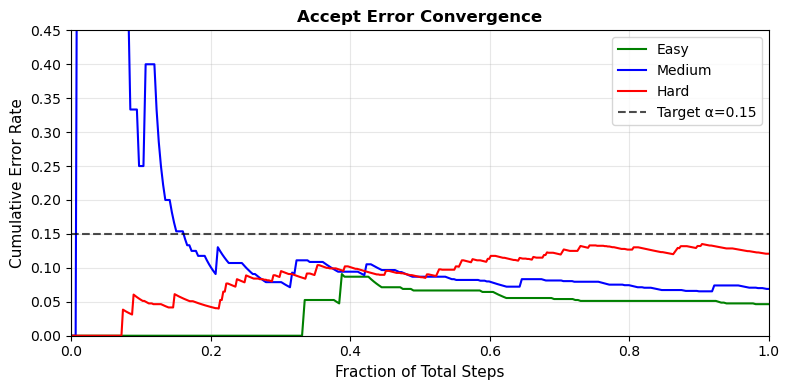

✓ Saved: ../results/reject_error_convergence.png


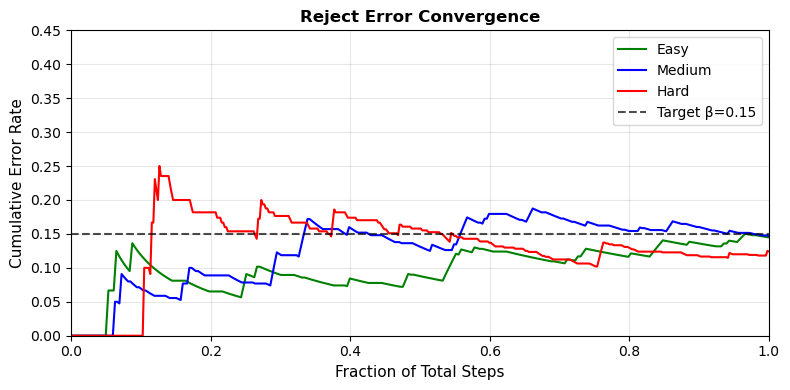

✓ Saved: ../results/error_convergence.png


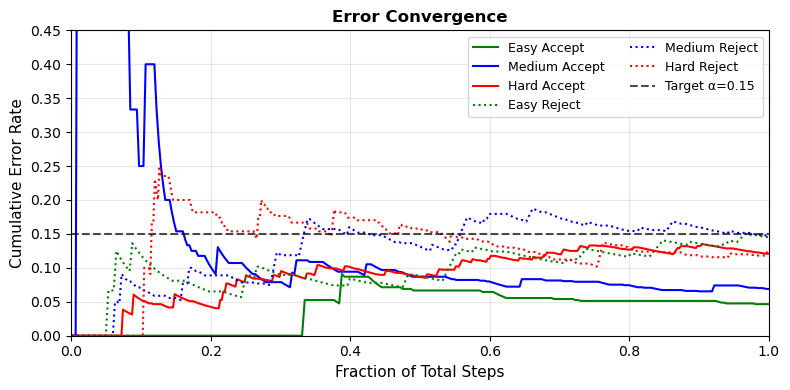

In [10]:
# Individual convergence plots
fig_accept = plot_accept_error_convergence(convergence_results, alpha, save_dir=RESULTS_DIR)
fig_reject = plot_reject_error_convergence(convergence_results, beta, save_dir=RESULTS_DIR)
fig_both = plot_both_error_convergence(convergence_results, alpha, beta, save_dir=RESULTS_DIR)

## 4. Main Pipeline: Accuracy vs Latency (Symmetric alpha=beta)

In [12]:
#alpha_beta_values = [
#    (0.01, 0.01), (0.03, 0.03), (0.05, 0.05), (0.07, 0.07),
#    (0.10, 0.10), (0.15, 0.15), (0.20, 0.20), (0.25, 0.25),
#    (0.30, 0.30), (0.40, 0.40), (0.50, 0.50),
#]

alpha_beta_values = [
    (0.01, 0.01), (0.03, 0.03)
]
pipeline_results = run_full_pipeline(
    repeated_data,
    alpha_beta_values,
    seed=42,
    n_runs=3,
    verbose=False,
    weak_baseline_n_values=[1, 2, 3, 4, 5],
)

# Save
save_pipeline_results(
    pipeline_results, RESULTS_DIR, 'pipeline_results_main_Best_of_N.json'
)

Computing baselines...
  Difficulty 2: Strong=97.5% @ 1.17 c/p, BoN-1=92.5%, BoN-2=95.0%, BoN-3=96.0%, BoN-4=95.0%, BoN-5=95.0%, 
  Difficulty 3: Strong=92.0% @ 1.50 c/p, BoN-1=80.5%, BoN-2=83.5%, BoN-3=86.0%, BoN-4=85.5%, BoN-5=84.5%, 
  Difficulty 5: Strong=63.5% @ 2.73 c/p, BoN-1=47.5%, BoN-2=51.0%, BoN-3=51.5%, BoN-4=54.5%, BoN-5=54.0%, 

Running grid search + experiments for each (α, β)...

  (α=0.01, β=0.01):

  (α=0.03, β=0.03):
✓ Saved pipeline results to: ../results/pipeline_results_main_Best_of_N.json


'../results/pipeline_results_main_Best_of_N.json'

✓ Saved: ../results/accuracy_vs_latency_easy.png


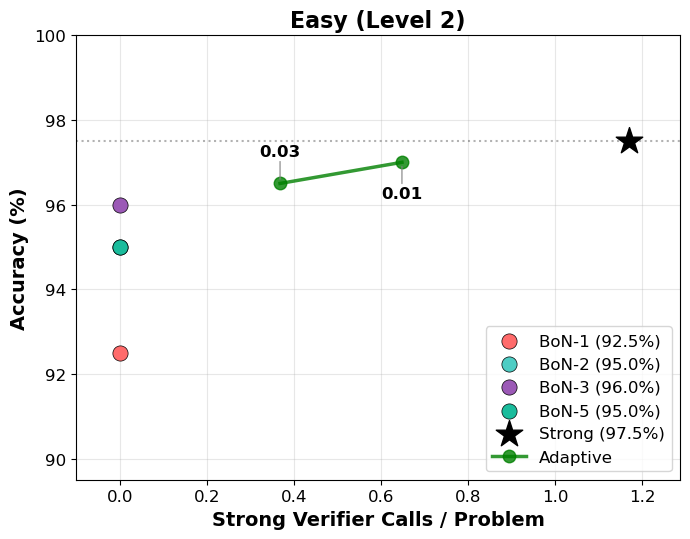

✓ Saved: ../results/accuracy_vs_latency_medium.png


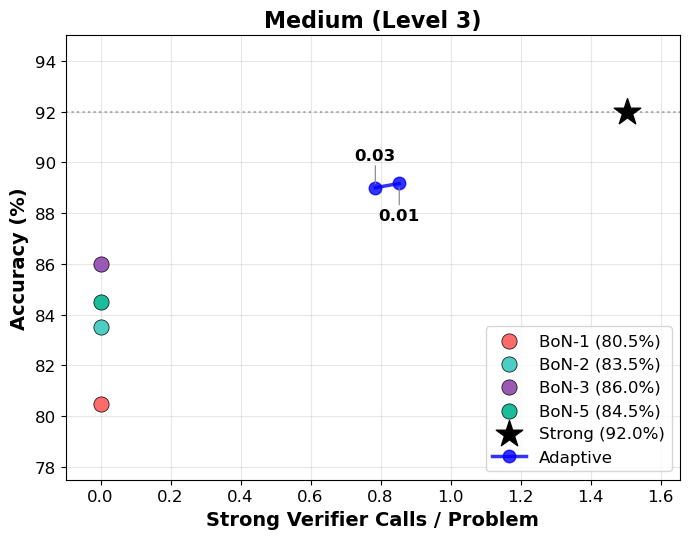

✓ Saved: ../results/accuracy_vs_latency_hard.png


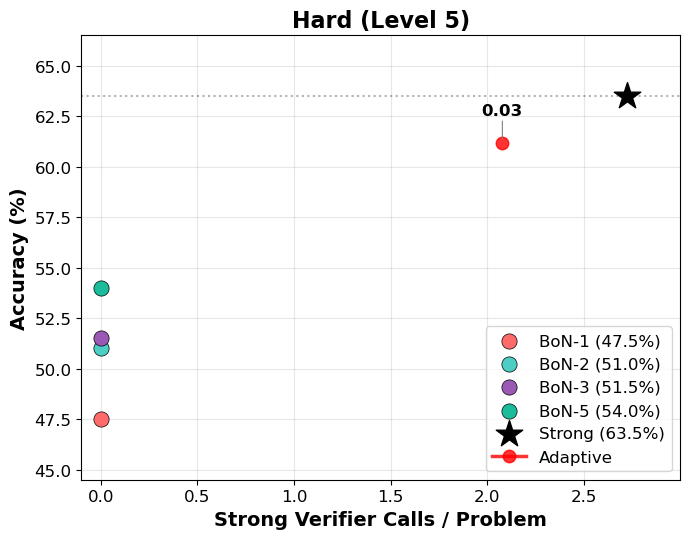

In [13]:
# Plot accuracy vs latency
figs = plot_accuracy_vs_latency(
    pipeline_results,
    save_dir=RESULTS_DIR,
    filename='accuracy_vs_latency.png',
    difficulties_to_plot=[2, 3, 5],
    weak_n_values_to_plot=[1, 2, 3, 5],
)

## 5. Appendix: Fixed-alpha Sweeps (Varying beta)

In [15]:
# Run sweeps for each fixed alpha
#beta_sweep = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]
beta_sweep = [0.01]
for fixed_alpha in [0.05, 0.10, 0.20]:
    ab_values = [(fixed_alpha, b) for b in beta_sweep]

    result = run_full_pipeline(
        repeated_data, ab_values,
        seed=42, n_runs=3, verbose=True,
        weak_baseline_n_values=[1, 2, 3, 4, 5],
    )

    save_pipeline_results(
        result, RESULTS_DIR,
        f'pipeline_results_appendix_alpha({fixed_alpha:.2f})_beta(sweep).Best_of_N.json',
    )
    print(f'\nDone: fixed alpha={fixed_alpha}\n')

Computing baselines...
  Difficulty 2: Strong=97.5% @ 1.17 c/p, BoN-1=92.5%, BoN-2=95.0%, BoN-3=96.0%, BoN-4=95.0%, BoN-5=95.0%, 
  Difficulty 3: Strong=92.0% @ 1.50 c/p, BoN-1=80.5%, BoN-2=83.5%, BoN-3=86.0%, BoN-4=85.5%, BoN-5=84.5%, 
  Difficulty 5: Strong=63.5% @ 2.73 c/p, BoN-1=47.5%, BoN-2=51.0%, BoN-3=51.5%, BoN-4=54.5%, BoN-5=54.0%, 

Running grid search + experiments for each (α, β)...

  (α=0.05, β=0.01):
    Diff 2: η=0.01, η_R=0.01, τ_A₀=0.85, τ_R₀=0.03, ae=0.050, re=0.015
    Diff 3: η=0.02, η_R=0.01, τ_A₀=0.99, τ_R₀=0.09, ae=0.046, re=0.011
    Diff 5: η=0.20, η_R=0.05, τ_A₀=0.93, τ_R₀=0.11, ae=0.056, re=0.032
✓ Saved pipeline results to: ../results/pipeline_results_appendix_alpha(0.05)_beta(sweep).Best_of_N.json

Done: fixed alpha=0.05

Computing baselines...
  Difficulty 2: Strong=97.5% @ 1.17 c/p, BoN-1=92.5%, BoN-2=95.0%, BoN-3=96.0%, BoN-4=95.0%, BoN-5=95.0%, 
  Difficulty 3: Strong=92.0% @ 1.50 c/p, BoN-1=80.5%, BoN-2=83.5%, BoN-3=86.0%, BoN-4=85.5%, BoN-5=84.5%, 
 

## 6. Appendix: Fixed-beta Sweeps (Varying alpha)

In [ ]:
alpha_sweep = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]

for fixed_beta in [0.05, 0.10, 0.20]:
    ab_values = [(a, fixed_beta) for a in alpha_sweep]

    result = run_full_pipeline(
        repeated_data, ab_values,
        seed=42, n_runs=3, verbose=True,
        weak_baseline_n_values=[1, 2, 3, 4, 5],
    )

    save_pipeline_results(
        result, RESULTS_DIR,
        f'pipeline_results_appendix_alpha(sweep)_beta({fixed_beta:.2f}).Best_of_N.json',
    )
    print(f'\nDone: fixed beta={fixed_beta}\n')

## 7. Multi-Sweep Overlay Plots

✓ Loaded pipeline results from: ../results/pipeline_results_appendix_alpha(0.05)_beta(sweep).Best_of_N.json
  Difficulties: [2, 3, 5]
  Weak baseline N values: [1, 2, 3, 4, 5]
  Number of (α,β) configs: 1
✓ Loaded pipeline results from: ../results/pipeline_results_appendix_alpha(0.10)_beta(sweep).Best_of_N.json
  Difficulties: [2, 3, 5]
  Weak baseline N values: [1, 2, 3, 4, 5]
  Number of (α,β) configs: 1
✓ Loaded pipeline results from: ../results/pipeline_results_appendix_alpha(0.20)_beta(sweep).Best_of_N.json
  Difficulties: [2, 3, 5]
  Weak baseline N values: [1, 2, 3, 4, 5]
  Number of (α,β) configs: 1
✓ Saved: ../results/accuracy_vs_latency_multi_alpha_easy.png


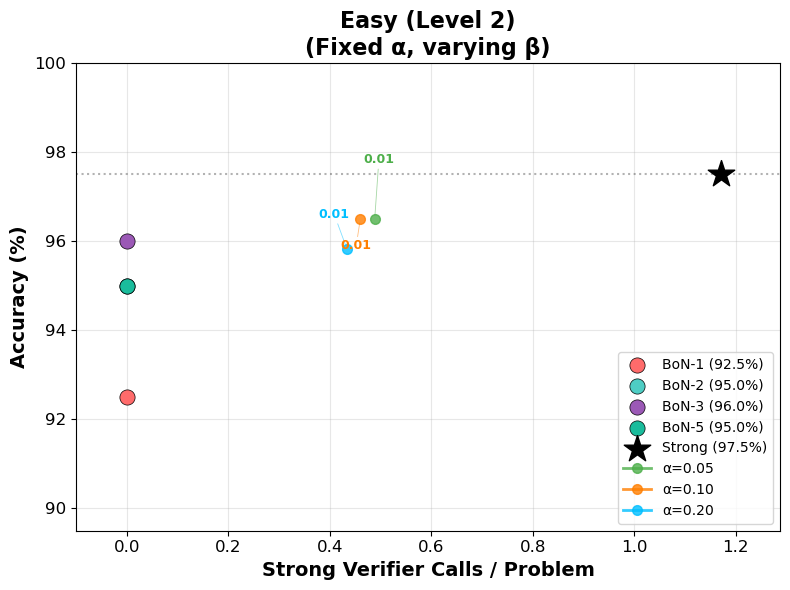

✓ Saved: ../results/accuracy_vs_latency_multi_alpha_medium.png


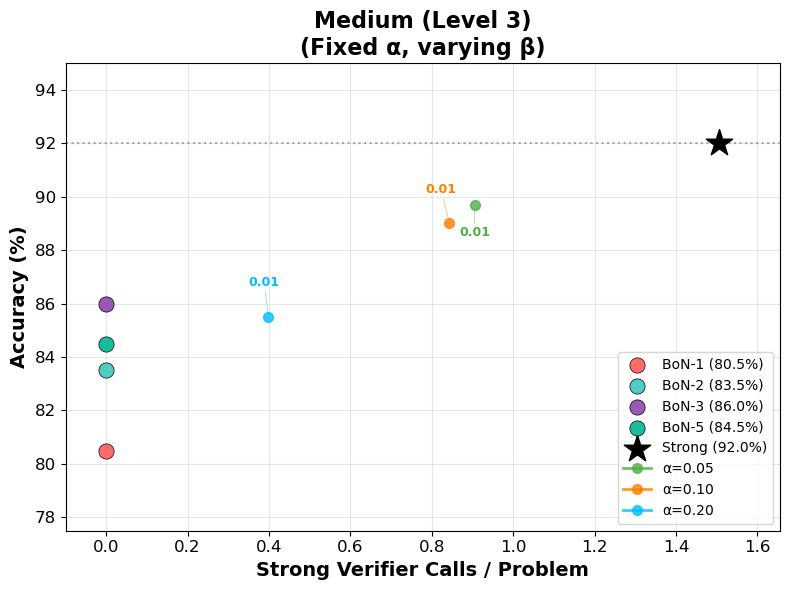

✓ Saved: ../results/accuracy_vs_latency_multi_alpha_hard.png


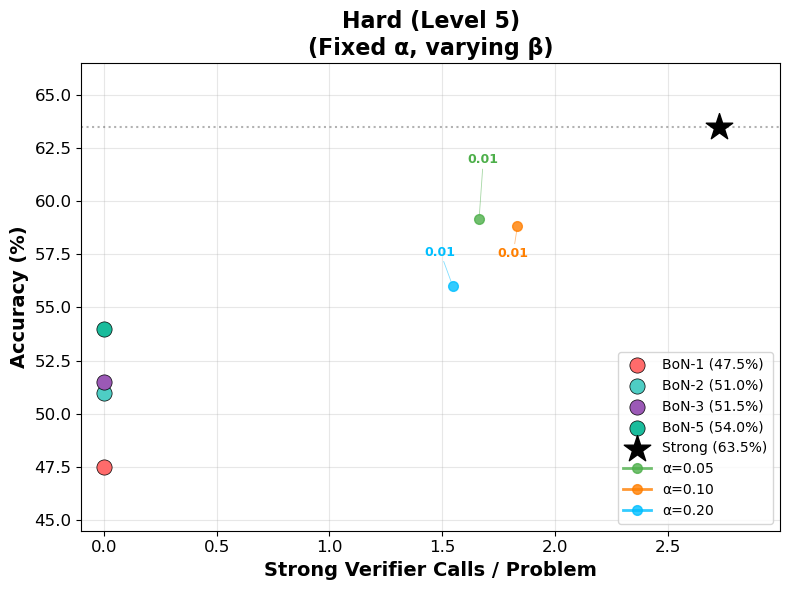

In [16]:
# Multi-alpha overlay (fixed alpha, varying beta)
results_multi_alpha = {}
for fixed_alpha in [0.05, 0.10, 0.20]:
    fname = f'pipeline_results_appendix_alpha({fixed_alpha:.2f})_beta(sweep).Best_of_N.json'
    results_multi_alpha[fixed_alpha] = load_pipeline_results(RESULTS_DIR, fname)

figs_alpha = plot_accuracy_vs_latency_multi_alpha(
    results_multi_alpha,
    save_dir=RESULTS_DIR,
    filename='accuracy_vs_latency_multi_alpha.png',
    difficulties_to_plot=[2, 3, 5],
    weak_n_values_to_plot=[1, 2, 3, 5],
)

In [17]:
# Multi-beta overlay (fixed beta, varying alpha)
results_multi_beta = {}
for fixed_beta in [0.05, 0.10, 0.20]:
    fname = f'pipeline_results_appendix_alpha(sweep)_beta({fixed_beta:.2f}).Best_of_N.json'
    results_multi_beta[fixed_beta] = load_pipeline_results(RESULTS_DIR, fname)

figs_beta = plot_accuracy_vs_latency_multi_beta(
    results_multi_beta,
    save_dir=RESULTS_DIR,
    filename='accuracy_vs_latency_multi_beta.png',
    difficulties_to_plot=[2, 3, 5],
    weak_n_values_to_plot=[1, 2, 3, 5],
)

FileNotFoundError: [Errno 2] No such file or directory: '../results/pipeline_results_appendix_alpha(sweep)_beta(0.05).Best_of_N.json'

## 8. Reload & Re-plot (for rebuttals / tweaking)

Use these cells to reload saved results and regenerate plots without re-running experiments.

In [ ]:
# Reload main results
loaded_results = load_pipeline_results(RESULTS_DIR, 'pipeline_results_main_Best_of_N.json')

# Re-plot with different settings
figs = plot_accuracy_vs_latency(
    loaded_results,
    save_dir=RESULTS_DIR,
    filename='accuracy_vs_latency_v2.png',
    difficulties_to_plot=[2, 3, 5],
    weak_n_values_to_plot=[1, 2, 3, 5],
    y_padding=5,
)